In [79]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from matplotlib import pyplot as plt

### Set Device ###

In [80]:
device = torch.device("cpu")
if torch.cuda.is_available():
    print("CUDA is available!")
    device = torch.device("cuda")
    print("GPU:", torch.cuda.get_device_name(0))

### Define Conditional Variational Autoencoder ###

In [94]:
import math

def convert_labels_to_one_hot(c, num_classes):
    one_hot = torch.zeros((len(c), num_classes))  # initialize one-hot tensor with zeros
    for i, label in enumerate(c):
        one_hot[i, label] = 1
    return one_hot


first_out_channels = 32
second_out_channels=64
class MultiLabel_cVAE(nn.Module):
    def __init__(self, x_dim, h_dim, z_dim, num_classes, input_channels, needs_one_hot=True, height = 218, width = 178):
        super(MultiLabel_cVAE, self).__init__()
        
        self.num_classes = num_classes
        self.height = height
        self.width = width
        
        # there are 2 max poolings which each half the sqrt dim of x.dim
        self.max_pooled_squared_dim = x_dim/((2*2)**2)
        self.max_pooled_sqrt_dim = int(math.sqrt(self.max_pooled_squared_dim))
        self.size_of_flattened = int(height/4) * int(width/4) * second_out_channels

        self.needs_one_hot = needs_one_hot
                
        self.encoderLayersCNN = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=first_out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=first_out_channels, out_channels=second_out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten()
        )
        self.encoderLayersLinear = nn.Sequential(
            nn.Linear(in_features=self.size_of_flattened + self.num_classes, out_features=h_dim),
            nn.ReLU())
        

        self.mu_sample_layer = nn.Linear(in_features=h_dim, out_features=z_dim)
        self.log_var_sample_layer = nn.Linear(in_features=h_dim, out_features=z_dim)
        
        # decoder part
        self.decoderLayersPt1 = nn.Sequential(
            nn.Linear(z_dim+self.num_classes, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, self.size_of_flattened)
        )
        self.decoderLayersPt2 = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=second_out_channels, out_channels=first_out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=first_out_channels, out_channels=input_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        
    def encoder(self, x, c_one_hot):
        h = self.encoderLayersCNN(x)
        concat = torch.cat([h, c_one_hot], dim=1)
        h = self.encoderLayersLinear(concat)
        return self.mu_sample_layer(h), self.log_var_sample_layer(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z, c_one_hot):
        zc = torch.cat([z, c_one_hot], dim=1)
        x = self.decoderLayersPt1(zc)
        x = x.view(-1, second_out_channels, int(self.width/4), int(self.height/4))
        x = self.decoderLayersPt2(x)
        return x
    
    def forward(self, x, c):
        c_onehot = c
        if self.needs_one_hot:
            c_onehot = torch.nn.functional.one_hot(c, num_classes=self.num_classes)
        # flatten
        mu, log_var = self.encoder(x, c_onehot)
        z = self.sampling(mu, log_var)
        return self.decoder(z, c_onehot), mu, log_var
    
    def generate(self, c):
        z = torch.randn(len(c), 2).to(device)
        c_onehot = torch.nn.functional.one_hot(c, num_classes=10).to(device)
        return self.decoder(z, c_onehot)

### Define Loss ###

In [82]:
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    #print the shapes
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

### Define Train and Test Methods ###

In [83]:
def train(model, epoch, train_loader, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(data, labels)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

def test(model, test_loader):
    model.eval()
    test_loss= 0
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.to(device)
            recon_batch, mu, log_var = model(data, labels)
            
            # sum up batch loss
            test_loss += loss_function(recon_batch, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

### Load MNIST Digit Dataset ###

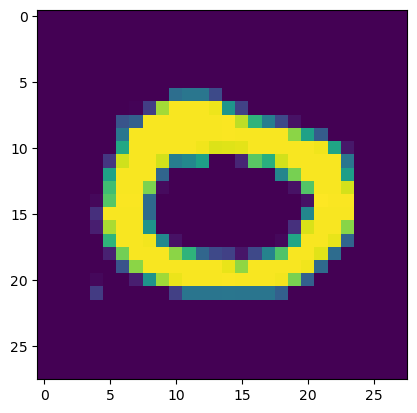

784


In [84]:
dataset = 'dataset'

batch_size = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root=dataset, train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root=dataset, train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Read a sample image from the dataset
sample_image, _ = next(iter(train_loader))

# Derive the input dimension dynamically
x_dim = sample_image.shape[-1] * sample_image.shape[-2]

# Display the sample image
plt.imshow(sample_image[0].permute(1, 2, 0))
plt.show()
print(x_dim)

In [85]:
# build model
vae = MultiLabel_cVAE(x_dim=x_dim, h_dim=512,z_dim=2, num_classes=10, input_channels=1, height = 28, width = 28, needs_one_hot=True)
vae = vae.to(device)

In [86]:
# define optimizer
optimizer = optim.Adam(vae.parameters())

In [87]:
for epoch in range(1, 15):
    train(vae, epoch, train_loader, optimizer)
    test(vae, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 631.993672
Train Epoch: 1 [10000/60000 (17%)]	Loss: 163.240908


KeyboardInterrupt: 

### Generate Samples ###

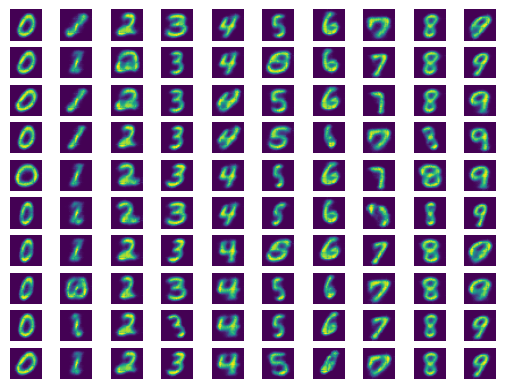

In [88]:
with torch.no_grad():
    c = torch.tensor([i % 10 for i in range(100)])
    generated_images = vae.generate(c)
    
    for (i, img) in enumerate(generated_images):
        plt.subplot(10, 10, i+1)
        plt.imshow(img.view(28, 28).cpu().numpy())
        plt.axis('off')


### Load CelebA Dataset ###

In [89]:
#Import CelebA Dataset
celeb_train_dataset = datasets.CelebA(root=dataset, split='train', download=True, transform=transforms.ToTensor())
celeb_test_dataset = datasets.CelebA(root=dataset, split='test', download=True, transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
celeb_train_loader = torch.utils.data.DataLoader(dataset=celeb_train_dataset, batch_size=batch_size, shuffle=True)
celeb_test_loader = torch.utils.data.DataLoader(dataset=celeb_test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


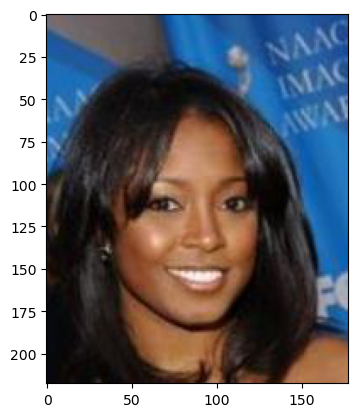

Features shapetorch.Size([100, 40])
Image Height:  218
Image Width:  178
Num Classes:  40
Attractive
Heavy_Makeup
High_Cheekbones
Mouth_Slightly_Open
No_Beard
Oval_Face
Smiling
Wavy_Hair
Wearing_Lipstick
Young


In [90]:
# View a sample image from the dataset
sample_image, features = next(iter(celeb_train_loader))
plt.show(plt.imshow(sample_image[0].permute(1, 2, 0)))

print("Features shape" + str(features.shape))

#Print heihgt and width of the image
image_height = sample_image.shape[-2]
image_width = sample_image.shape[-1]
print("Image Height: ", image_height)
print("Image Width: ", image_width)
num_classes = len(celeb_train_dataset.attr_names[:-1])
print("Num Classes: ", num_classes)

for (i, feature) in enumerate(features[0]):
    if (feature == 1):
        print(celeb_train_dataset.attr_names[i])


### Train VAE on CelebA Dataset ###

In [95]:
x_dim = image_width * image_height

celeb_vae = MultiLabel_cVAE(x_dim=x_dim, h_dim=512,z_dim=2, num_classes=num_classes, input_channels=3, needs_one_hot=False)
celeb_vae = celeb_vae.to(device)

#Run one sample through the model
sample_image, features = next(iter(celeb_train_loader))
sample_image = sample_image.to(device)
features = features.to(device)
recon_batch, mu, log_var = celeb_vae(sample_image, features)
print("Recon Batch Shape: ", recon_batch.shape)

Recon Batch Shape:  torch.Size([100, 3, 176, 216])


In [65]:
# define optimizer
optimizer = optim.Adam(celeb_vae.parameters())

for epoch in range(1, 15):
    train(celeb_vae, epoch, celeb_train_loader, optimizer)
    test(celeb_vae, celeb_test_loader)

torch.Size([100, 152064])


ValueError: Using a target size (torch.Size([100, 3, 218, 178])) that is different to the input size (torch.Size([100, 3, 176, 216])) is deprecated. Please ensure they have the same size.

### Generate Samples ###

In [45]:
# TODO